In [1]:

%pprint
import sys
sys.path.insert(1, '../py')

Pretty printing has been turned OFF


In [2]:

from notebook_utils import NotebookUtilities
import os.path as osp
import re
import pandas as pd
import matplotlib.pyplot as plt
import textwrap
from matplotlib.patches import Rectangle
import wikipedia
bs = wikipedia.BeautifulSoup
import numpy as np

nu = NotebookUtilities(
    data_folder_path=osp.abspath('../data'),
    saves_folder_path=osp.abspath('../saves')
)

In [3]:

generations_df = nu.load_object('generations_df')
turning_numbers_df = nu.load_object('turning_numbers_df')
turnings_df = nu.load_object('turnings_df')

In [4]:

if nu.pickle_exists('mass_senators_df'): mass_senators_df = nu.load_object('mass_senators_df')
else:
    tables_url = 'https://en.wikipedia.org/wiki/List_of_United_States_senators_from_Massachusetts'
        
    # Get the BeautifulSoup object for the Wikipedia page
    page_soup = nu.get_page_soup(tables_url)
    
    # Find all the tables on the Wikipedia page
    table_soups_list = page_soup.find_all('table', attrs={'class': 'wikitable'})

    # Get the data frame for the first table on the Wikipedia page
    table_soup = table_soups_list[0]
    mass_senators_df = nu.get_page_tables(str(table_soup), verbose=False)[0]
    mass_senators_df.columns = [
        prefix.replace('Class ', 'class_') + '_' + suffix.replace('#', 'number').replace(' ', '_').replace('T', 'term').lower()
        for suffix, prefix in zip(mass_senators_df.iloc[176].values, mass_senators_df.iloc[177].values)
    ]
    # print({f'{cn}': f'{cn}' for cn in mass_senators_df.columns})
    mass_senators_df = mass_senators_df.iloc[2:174].rename(
        columns={
            'class_1_number': 'class_1_office_rank', 'class_1_senator': 'class_1_senator_name', 'class_1_term': 'class_1_senator_term',
            'C_c': 'congress_ordinal',
            'class_2_term': 'class_2_senator_term', 'class_2_senator': 'class_2_senator_name', 'class_2_number': 'class_2_office_rank'
        }
    )
    prefix = 'class_1_'
    columns_list = ['congress_ordinal'] + [cn for cn in mass_senators_df.columns if cn.startswith(prefix)]
    class_1_df = mass_senators_df[columns_list].reset_index(drop=True)
    class_1_df = class_1_df.rename(columns={cn: cn.replace(prefix, '') for cn in class_1_df.columns})
    class_1_df['senate_class'] = 1
    prefix = 'class_2_'
    columns_list = ['congress_ordinal'] + [cn for cn in mass_senators_df.columns if cn.startswith(prefix)]
    class_2_df = mass_senators_df[columns_list].reset_index(drop=True)
    class_2_df = class_2_df.rename(columns={cn: cn.replace(prefix, '') for cn in class_2_df.columns})
    class_2_df['senate_class'] = 2
    mass_senators_df = pd.concat([class_1_df, class_2_df], axis='index').reset_index(drop=True)
    # display(mass_senators_df)
    
    # Create the senator bios data frame from the first table
    if nu.pickle_exists('mass_senator_bios_df'): mass_senator_bios_df = nu.load_object('mass_senator_bios_df')
    else:
        rows_list = []
        tr_soups_list = table_soup.find_all('tr')
        for tr_soup in tr_soups_list:
            td_soups_list = tr_soup.find_all('td', attrs={'colspan': False})
            for td_soup in td_soups_list:
                img_soups_list = td_soup.find_all('img', attrs={'width': '100'})
                if img_soups_list:
                    senator_name = td_soup.text.strip()
                    row_dict = {'senator_name': senator_name}
                    a_soup = td_soup.find_all('a', attrs={'title': True})[0]
                    bio_title = a_soup['title']
                    row_dict['page_title'] = bio_title
                    bio_obj = wikipedia.WikipediaPage(title=bio_title)
                    bio_html = bio_obj.html()
                    bio_soup = bs(bio_html, 'html.parser')
                    # <th scope="row" class="infobox-label">Born</th>
                    infobox_label_soups_list = bio_soup.find_all('th', attrs={'scope': 'row', 'class': 'infobox-label'})
                    for infobox_label_soup in infobox_label_soups_list:
                        key = infobox_label_soup.text.strip()
                        value = infobox_label_soup.find_next('td', attrs={'class': 'infobox-data'}).text.strip()
                        # print(key, value)
                        row_dict[key] = value
                    rows_list.append(row_dict)
        mass_senator_bios_df = pd.DataFrame(rows_list).rename(columns={
            'Preceded by': 'preceded_by', 'Succeeded by': 'succeeded_by', 'Born': 'year_of_birth', 'Died': 'year_of_death',
            'Political party': 'political_party', 'Alma mater': 'alma_mater', 'Profession': 'profession', 'Lieutenant': 'lieutenant', 'Signature': 'signature', 'Governor': 'governor',
            'Children': 'children', 'Occupation': 'occupation', 'Constituency': 'constituency', 'Spouses': 'spouses', 'Branch/service': 'branch_service', 'Rank': 'rank',
            'Battles/wars': 'battles_wars', 'President': 'president', 'Resting place': 'resting_place', 'Spouse': 'spouse', 'Education': 'education',
            'Relations': 'relations', 'Vice President': 'vice_president', 'Nominated by': 'nominated_by', 'Parents': 'parents', 'Relatives': 'relatives',
            'Allegiance': 'allegiance', 'Years\xa0of service': 'years_of_service', 'Other politicalaffiliations': 'other_political_affiliations', 'Appointed by': 'appointed_by',
            'Commands': 'commands', 'Deputy': 'deputy', 'Spouse(s)': 'spouses', 'Pope': 'pope', 'Parent(s)': 'parents', 'Unit': 'unit', 'Leader': 'leader', 'Nickname': 'nickname',
            'Awards': 'awards', 'Website': 'website'
        })
        # print({f'{cn}': f'{cn}' for cn in mass_senator_bios_df.columns}); raise
        nu.store_objects(mass_senator_bios_df=mass_senator_bios_df)
    
    # Get integer columns
    year_regex = re.compile(r'\d{4}')
    for senator_name in mass_senators_df.senator_name:
        main_mask_series = (mass_senators_df.senator_name == senator_name)
        bio_mask_series = (mass_senator_bios_df.senator_name == senator_name)
        
        # Get year of birth
        year_of_birth = mass_senator_bios_df[bio_mask_series].year_of_birth
        if year_of_birth.shape[0] == 1:
            if (str(year_of_birth.squeeze()) == 'nan'): year_of_birth = np.nan
            else: year_of_birth = int(year_regex.search(str(year_of_birth.squeeze())).group())
        elif year_of_birth.shape[0] == 0: year_of_birth = np.nan
        else: year_of_birth = int(year_of_birth.map(lambda x: year_regex.search(str(x)).group()).mode().values[0])
        mass_senators_df.loc[main_mask_series, 'year_of_birth'] = year_of_birth
        
        # Get year of death
        year_of_death = mass_senator_bios_df[bio_mask_series].year_of_death
        if year_of_death.shape[0] == 1:
            if (str(year_of_death.squeeze()) == 'nan'): year_of_death = np.nan
            else: year_of_death = int(year_regex.search(str(year_of_death.squeeze())).group())
        elif year_of_death.shape[0] == 0: year_of_death = np.nan
        else: year_of_death = year_of_death.map(lambda x: int(year_regex.search(str(x)).group())).mode().values[0]
        mass_senators_df.loc[main_mask_series, 'year_of_death'] = year_of_death
    
    # Get the first year of the term
    mass_senators_df['year_term_begin'] = mass_senators_df.years_in_office.map(lambda x: int(year_regex.search(str(x)).group()))
    
    # Add generation name and turnings archetype
    for row_index, row_series in mass_senators_df.iterrows():
        year_of_birth = row_series.year_of_birth
        mask_series = (generations_df.birth_year_begin <= year_of_birth) & (generations_df.birth_year_end >= year_of_birth)
        if (generations_df[mask_series].shape[0] >= 1):
            generation_name = generations_df[mask_series].index.tolist()[0]
            turnings_archetype = generations_df[mask_series].turnings_archetype.tolist()[0]
        elif (generations_df[mask_series].shape[0] == 2):display(generations_df[mask_series].index); display(row_series); raise
        else:
            generation_name = np.nan
            turnings_archetype = np.nan
        mass_senators_df.loc[row_index, 'generation_name'] = generation_name
        mass_senators_df.loc[row_index, 'turnings_archetype'] = turnings_archetype
    
    # Add turning number, name, and type
    for row_index, row_series in mass_senators_df.iterrows():
        year_term_begin = row_series.year_term_begin
        mask_series = (turnings_df.turning_year_begin <= year_term_begin) & (turnings_df.turning_year_end >= year_term_begin)
        if (turnings_df[mask_series].shape[0] >= 1):
            
            # Get turning name
            turning_name = turnings_df[mask_series].index.tolist()[0]
            
            # Get turning number
            turning_number = turnings_df[mask_series].turning_number.tolist()[0]
            
        elif (turnings_df[mask_series].shape[0] == 2):display(turnings_df[mask_series].index); display(row_series); raise
        else:
            turning_name = np.nan
            turning_number = np.nan
        
        # Get turning type
        mask_series = (turning_numbers_df.index == turning_number)
        if (turning_numbers_df[mask_series].shape[0] >= 1): turning_type = turning_numbers_df[mask_series].turning_type.tolist()[0]
        else: turning_type = np.nan
        
        mass_senators_df.loc[row_index, 'turning_name'] = turning_name
        mass_senators_df.loc[row_index, 'turning_number'] = turning_number
        mass_senators_df.loc[row_index, 'turning_type'] = turning_type
    
    # Numericalize integer columns
    for cn in ['year_of_birth', 'year_of_death', 'office_rank', 'year_term_begin']:
        mass_senators_df[cn] = pd.to_numeric(mass_senators_df[cn], errors='coerce')
    mass_senators_df.turning_number = mass_senators_df.turning_number.astype(int)

    # Add final computations and make the name the index
    mass_senators_df['age_at_inauguration'] = (mass_senators_df.year_term_begin - mass_senators_df.year_of_birth)
    mass_senators_df = mass_senators_df.set_index('senator_name')
    
    nu.store_objects(mass_senators_df=mass_senators_df)

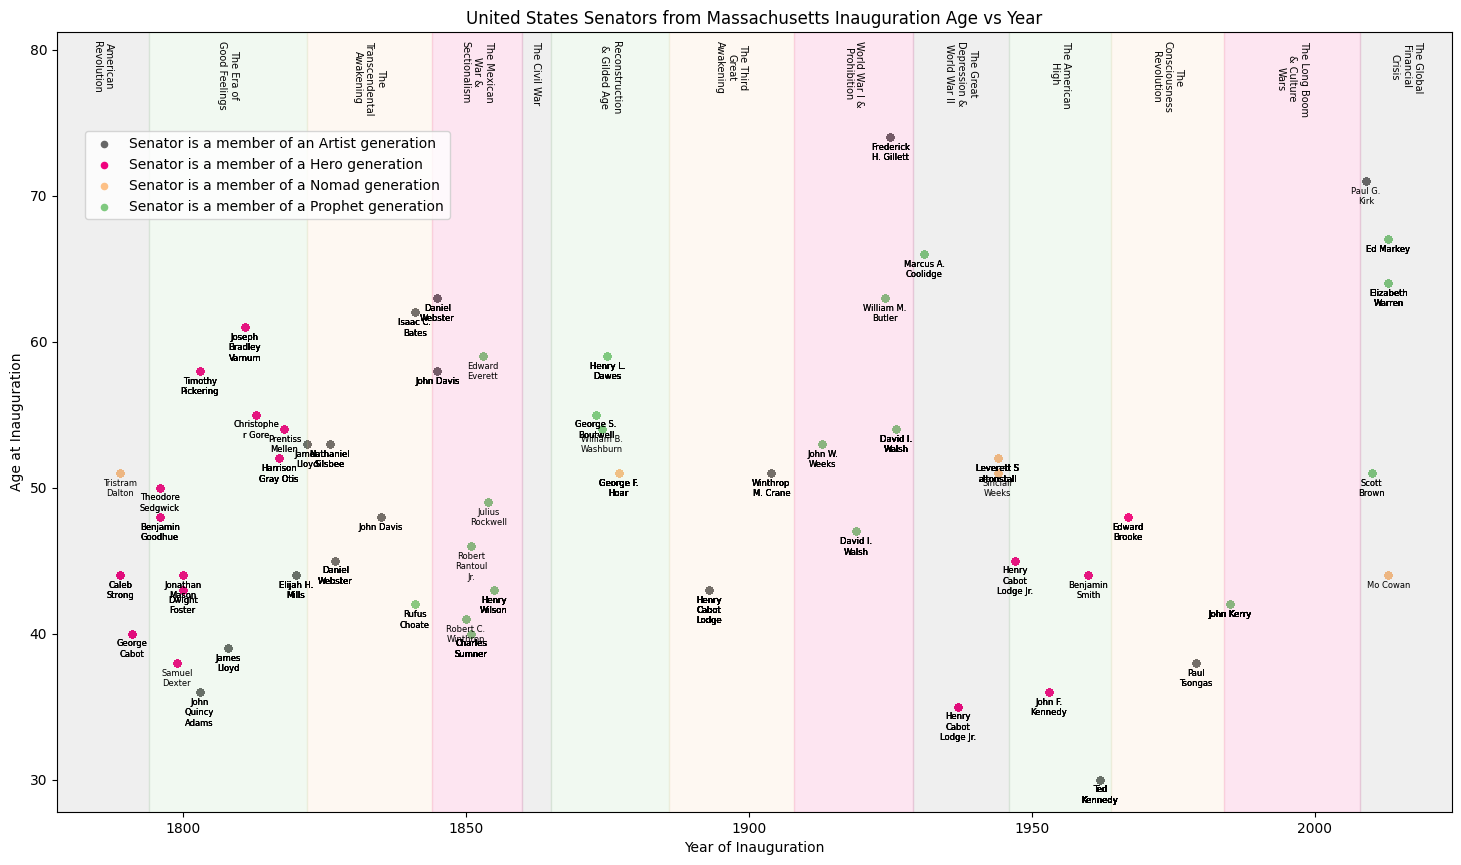

In [5]:

df1 = turnings_df.reset_index()
df2 = generations_df.reset_index()
on_list = list(set(df1.columns).intersection(set(df2.columns)))
df3 = df1.merge(df2, on=on_list)
nu.plot_inauguration_age(
    inauguration_df=mass_senators_df, groupby_column_name='turnings_archetype', xname='year_term_begin', leader_designation='Senator',
    label_infix='is a member of', label_suffix='generation', info_df=df3,
    title_prefix='United States Senators from Massachusetts'
)

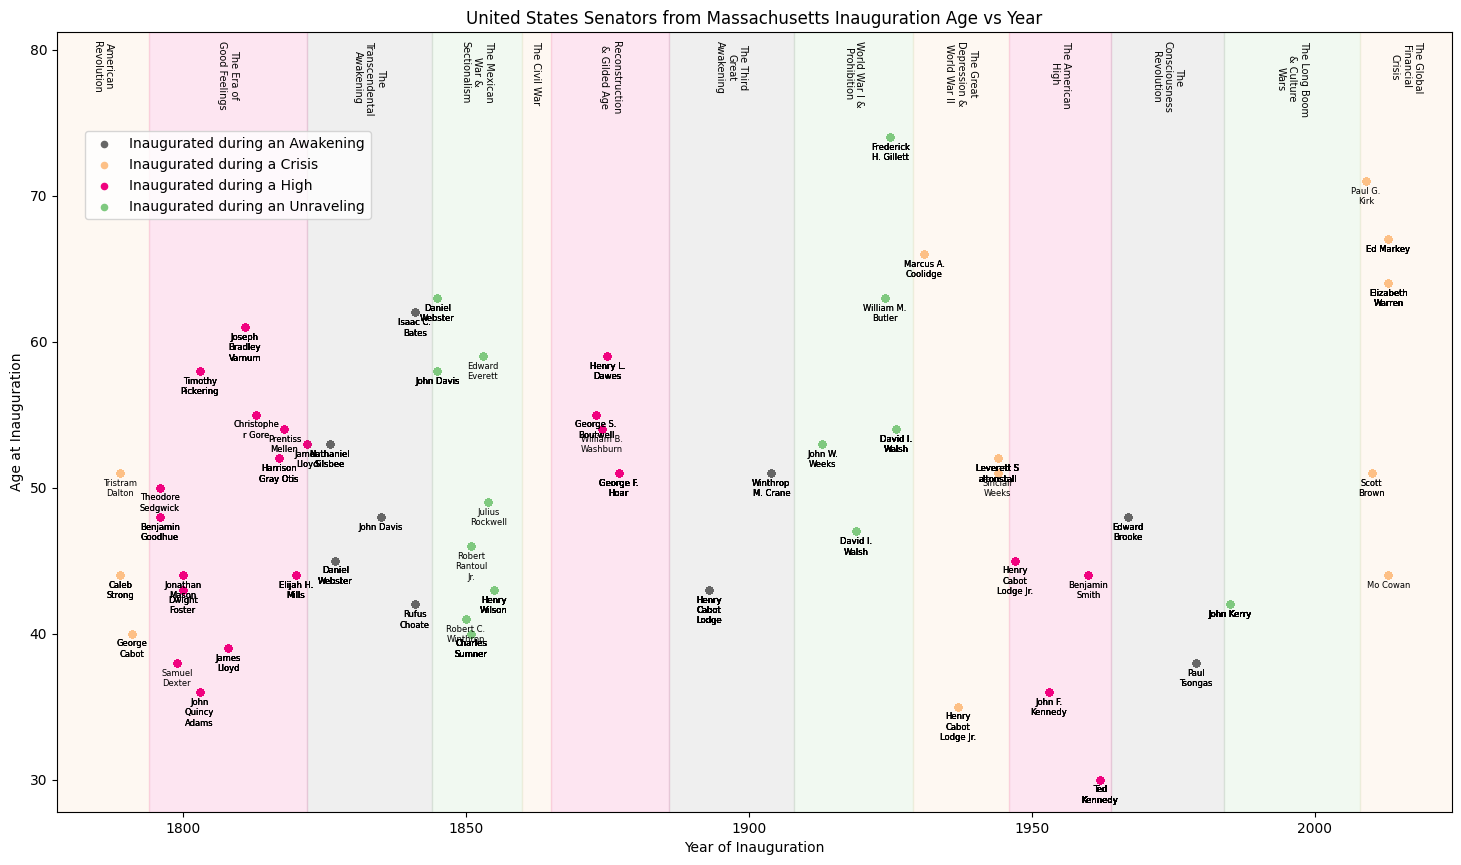

In [6]:

df1 = turnings_df.reset_index()
df2 = turning_numbers_df.reset_index().rename(columns={'index': 'turning_number'})
on_list = list(set(df1.columns).intersection(set(df2.columns)))
df3 = df1.merge(df2, on=on_list)
df4 = generations_df.reset_index()
on_list = list(set(df3.columns).intersection(set(df4.columns)))
df5 = df3.merge(df4, on=on_list)
nu.plot_inauguration_age(
    inauguration_df=mass_senators_df, groupby_column_name='turning_type', xname='year_term_begin', leader_designation='Inaugurated',
    label_infix='during', label_suffix='', info_df=df5,
    title_prefix='United States Senators from Massachusetts'
)